# Initializing

In [1]:
# insta-msc
import os
import argparse
import time
import pandas as pd
import lightgbm as lgb

from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils.utils import split_dataset

# bayesian opt
import numpy as np
import torch
from torch import nn, distributions
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy import linalg
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

torch.set_default_tensor_type(torch.FloatTensor)

# plotting
import seaborn as sns
sns.set_style("darkgrid")

%matplotlib inline


# import from scripts
import importlib
from acqusition_functions import probability_of_improvement, expected_improvement, GP_UCB, GP_UCB_approx

# Predicting popularity on Instagram

In [2]:
import lightgbm_functions
#importlib.reload(lightgbm_functions)

In [3]:
# load data set
df = lightgbm_functions.load_data_set()

In [4]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2'},
    'num_leaves': 320, #256,
    'learning_rate': 0.025118864315095798, #0.05,
    'feature_fraction': .6, #0.9,
    'lambda_l2': .001, #0
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'max_bin': 255,
    'verbose': 0
}

# train GBM
lightgbm_functions.train_gbm(df, params, verbose=False)

0.43820734550851376

# Bayesian Optimization
At first, I will setup the required functions for using Bayesian Optimization (BO).





In [5]:
from bayesian_optimization import squared_exponential_kernel, fit_predictive_GP, optimize_GP_hyperparams, sample_initial_parameters

### First experiment: single parameter
We will start by optimizing the parameters sequentially, e.g. only optimizing one parameter at a time.

In [6]:
PARAM = 'lr'

LR = 0.04
LEAVES = 150
FRAC = 0.59
L2 = 0.025

if PARAM == 'lr':
    X = np.linspace(0.01,1,100) #0.1**(np.linspace(1,5,100)) #np.linspace(0.1,1,99)

elif PARAM == 'leaves':
    X = np.linspace(0,1000,101)
    X[0] = 2
    
elif PARAM == 'frac':
    X = np.linspace(0.5,1,51)
    
elif PARAM == 'l2':
    X = X = np.linspace(0.01,1,100)
    
# Standardize
X_mean = np.mean(X)
X_std = np.std(X)
X = (X - X_mean) / X_std

X_sample = sample_initial_parameters(n_samples=5, search_space=X, method='uniform') 

100%|██████████| 5/5 [00:00<00:00, 17490.84it/s]


### Define oracle

In [7]:
# This function is created specific for LightGBM and Bayesian Optimization of a single parameter:
# - learning rate
def query_the_objective(df, x, X_mean=X_mean, X_std=X_std, param=PARAM, lr=LR, leaves=LEAVES, frac=FRAC, l2=L2, transform=True):
    if transform:
        x = x * X_std + X_mean

    
    if param=='lr':
        lr = x
        if transform:
            lr = 0.1**( x *100/20)
    elif param=='leaves':
        leaves = int(x)
    elif param=='frac':
        frac = x
    elif param=='l2':
        l2 = x
        if transform:
            lr = 0.1**( x * 6)
    else:
        print("Wrong 'param'!")
        
    # specify your configurations as a dict       
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2'},
        'num_leaves': leaves, #320, #256,
        'learning_rate': lr, #0.05,
        'feature_fraction': frac, #.6, #0.9,
        'lambda_l2': l2, #.001, #0
        #'bagging_fraction': 0.8,
        #'bagging_freq': 5,
        'max_bin': 255,
        'verbose': 0
    }
    
    
    # train GBM
    rho = lightgbm_functions.train_gbm(df, params, verbose=False)
    return rho

### Get the label to the initial points through the oracle (query the objective function)

In [8]:
# Query the objective
y_sample = []
for x in tqdm(X_sample):
    y_sample.append(query_the_objective(df, x, X_mean, X_std, param=PARAM))


# bayesian optimization loop
# compute the current best 
current_best = np.max(y_sample)
print(current_best)

100%|██████████| 5/5 [00:22<00:00,  4.78s/it]

0.44600736821073184


First, we define the prior, the free parameter $\varepsilon$, acquistion function and the number of iterations.

In [10]:
# Prior over lengthscale
prior_mean = 0.41
prior_std = 0.1

print(np.mean(y_sample))
print(np.std(y_sample))

# trade-off between exploration and explotation
eps = 0.01

# Choose acquisition function
acquisition = 'probability'

# number of iterations
T = 2

0.4147725741977644
0.02279923010767995




Perform the Bayesian Optimization

lengtscale: 0.443, output_variance: 0.13798, noise_variance 0.00001, current_best: 0.44601


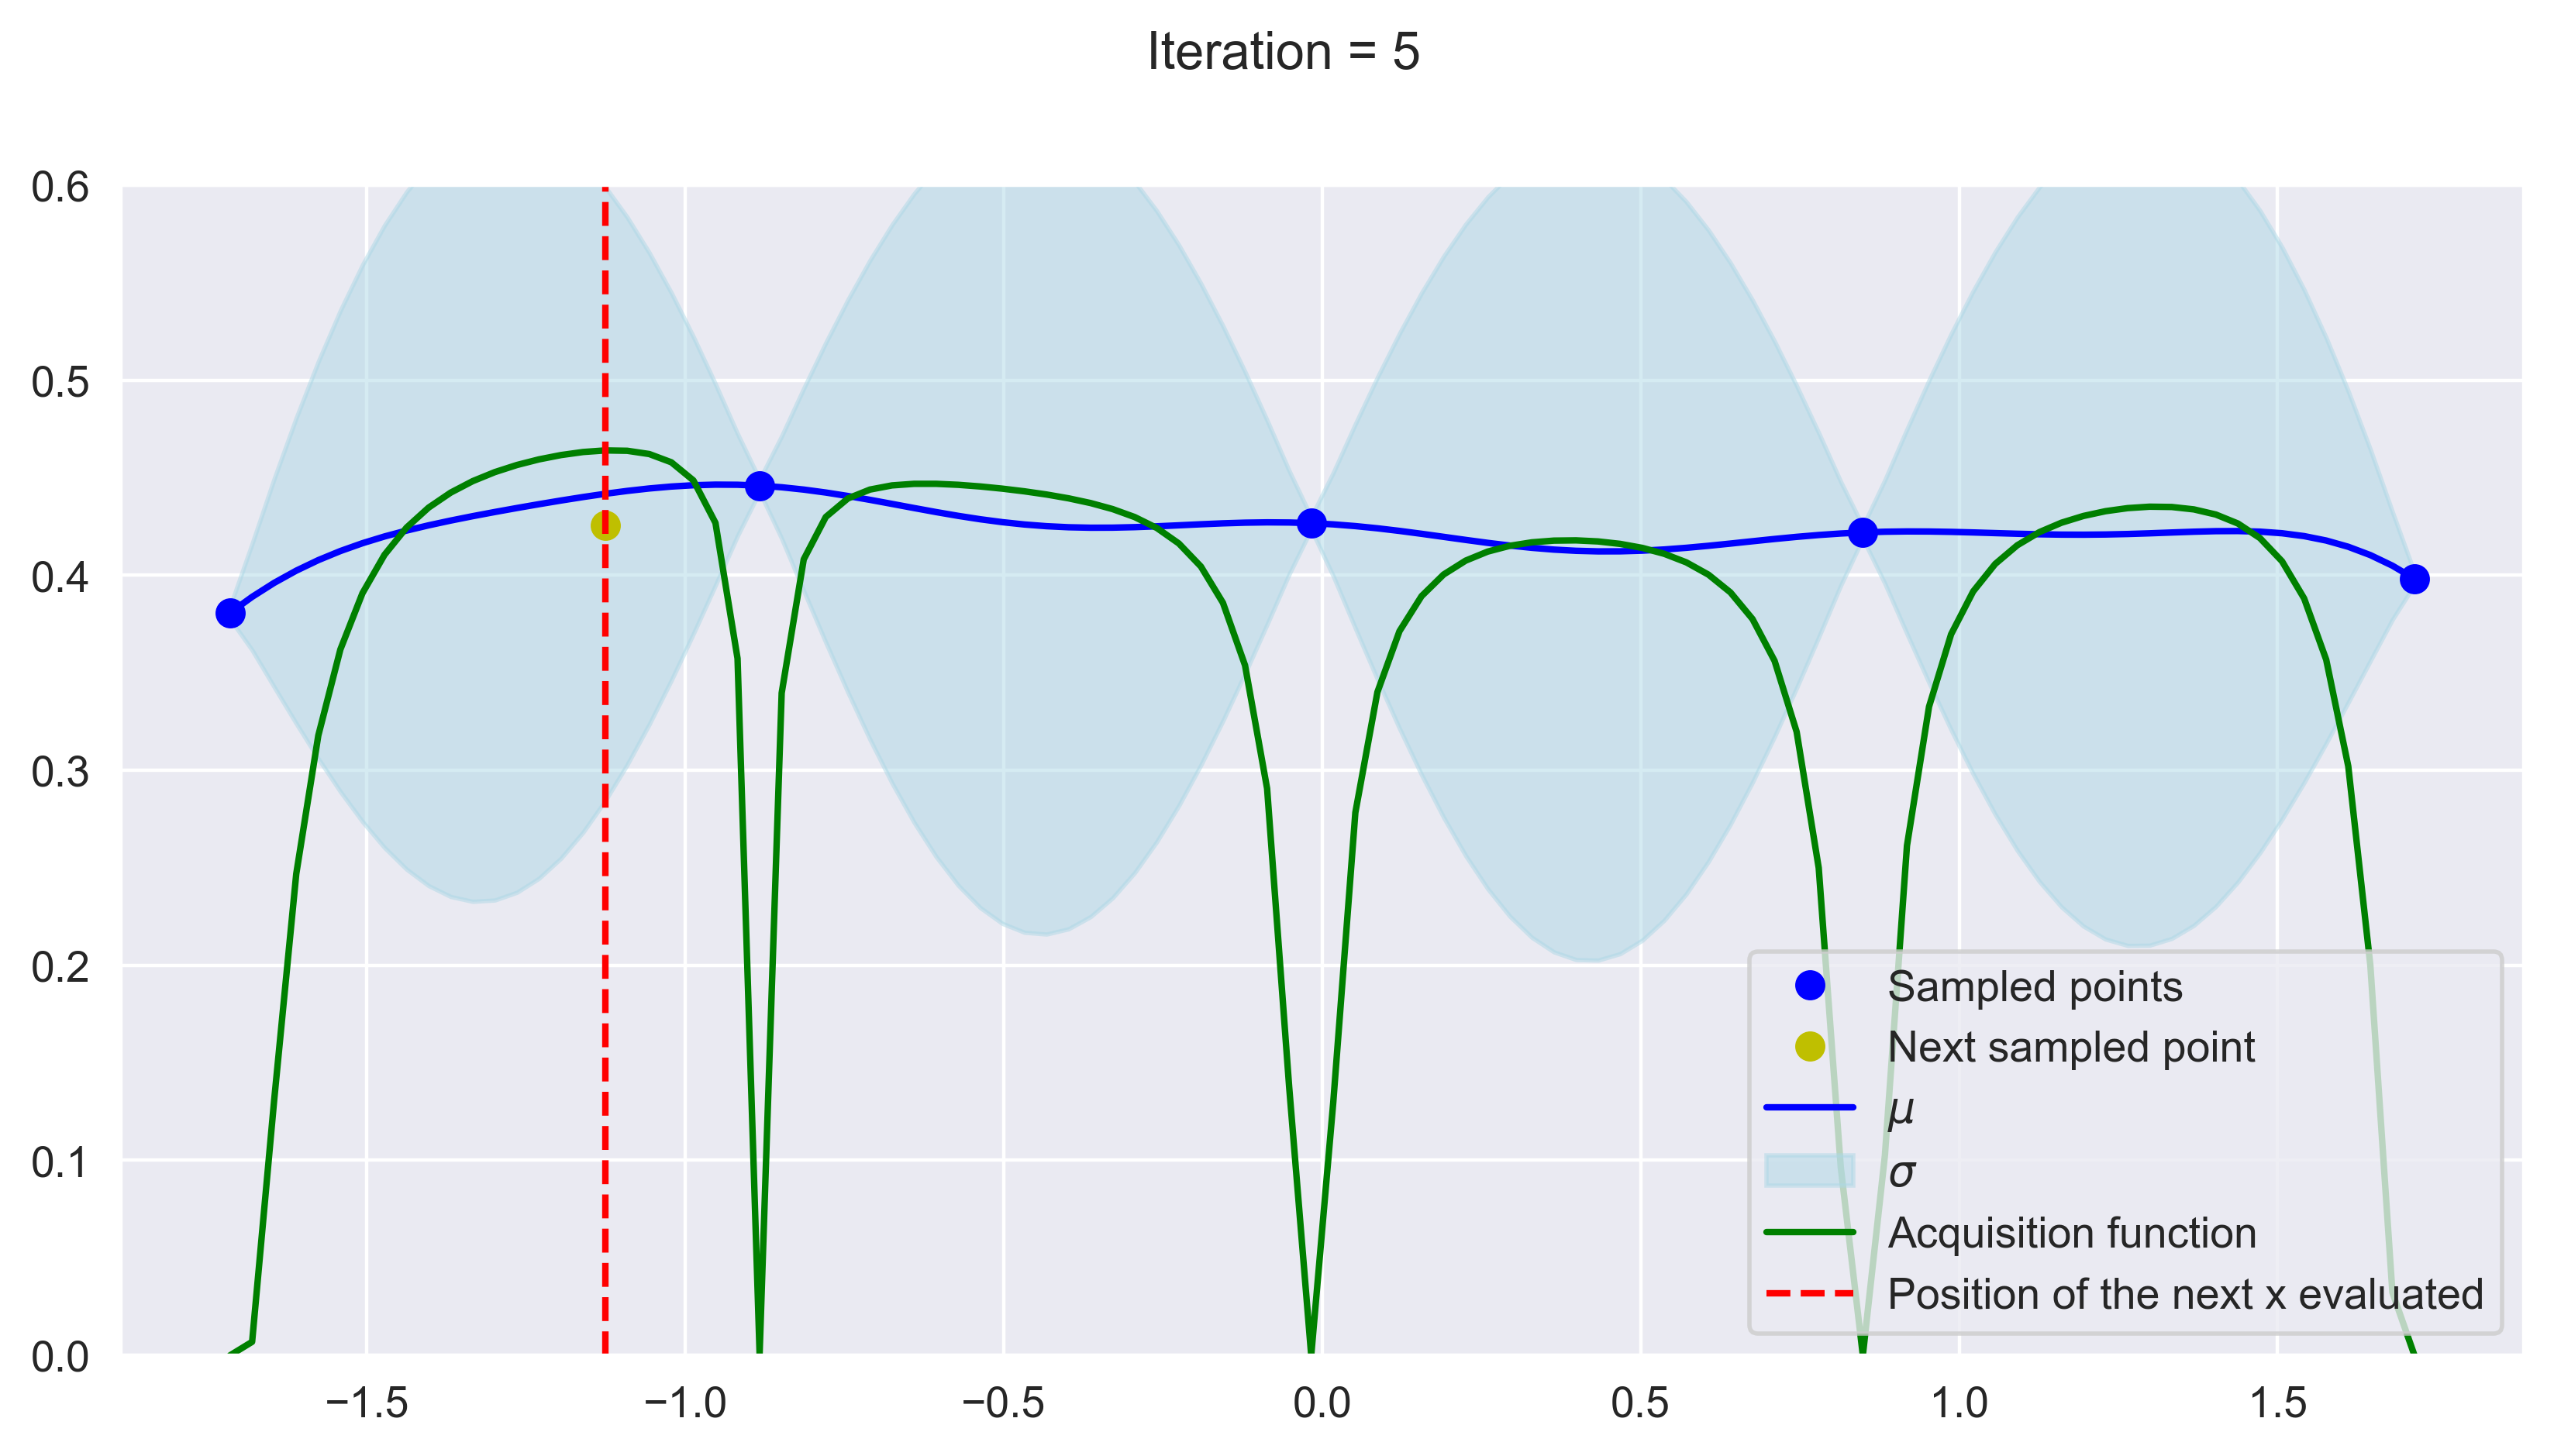

lengtscale: 0.499, output_variance: 0.10562, noise_variance 0.00001, current_best: 0.44601


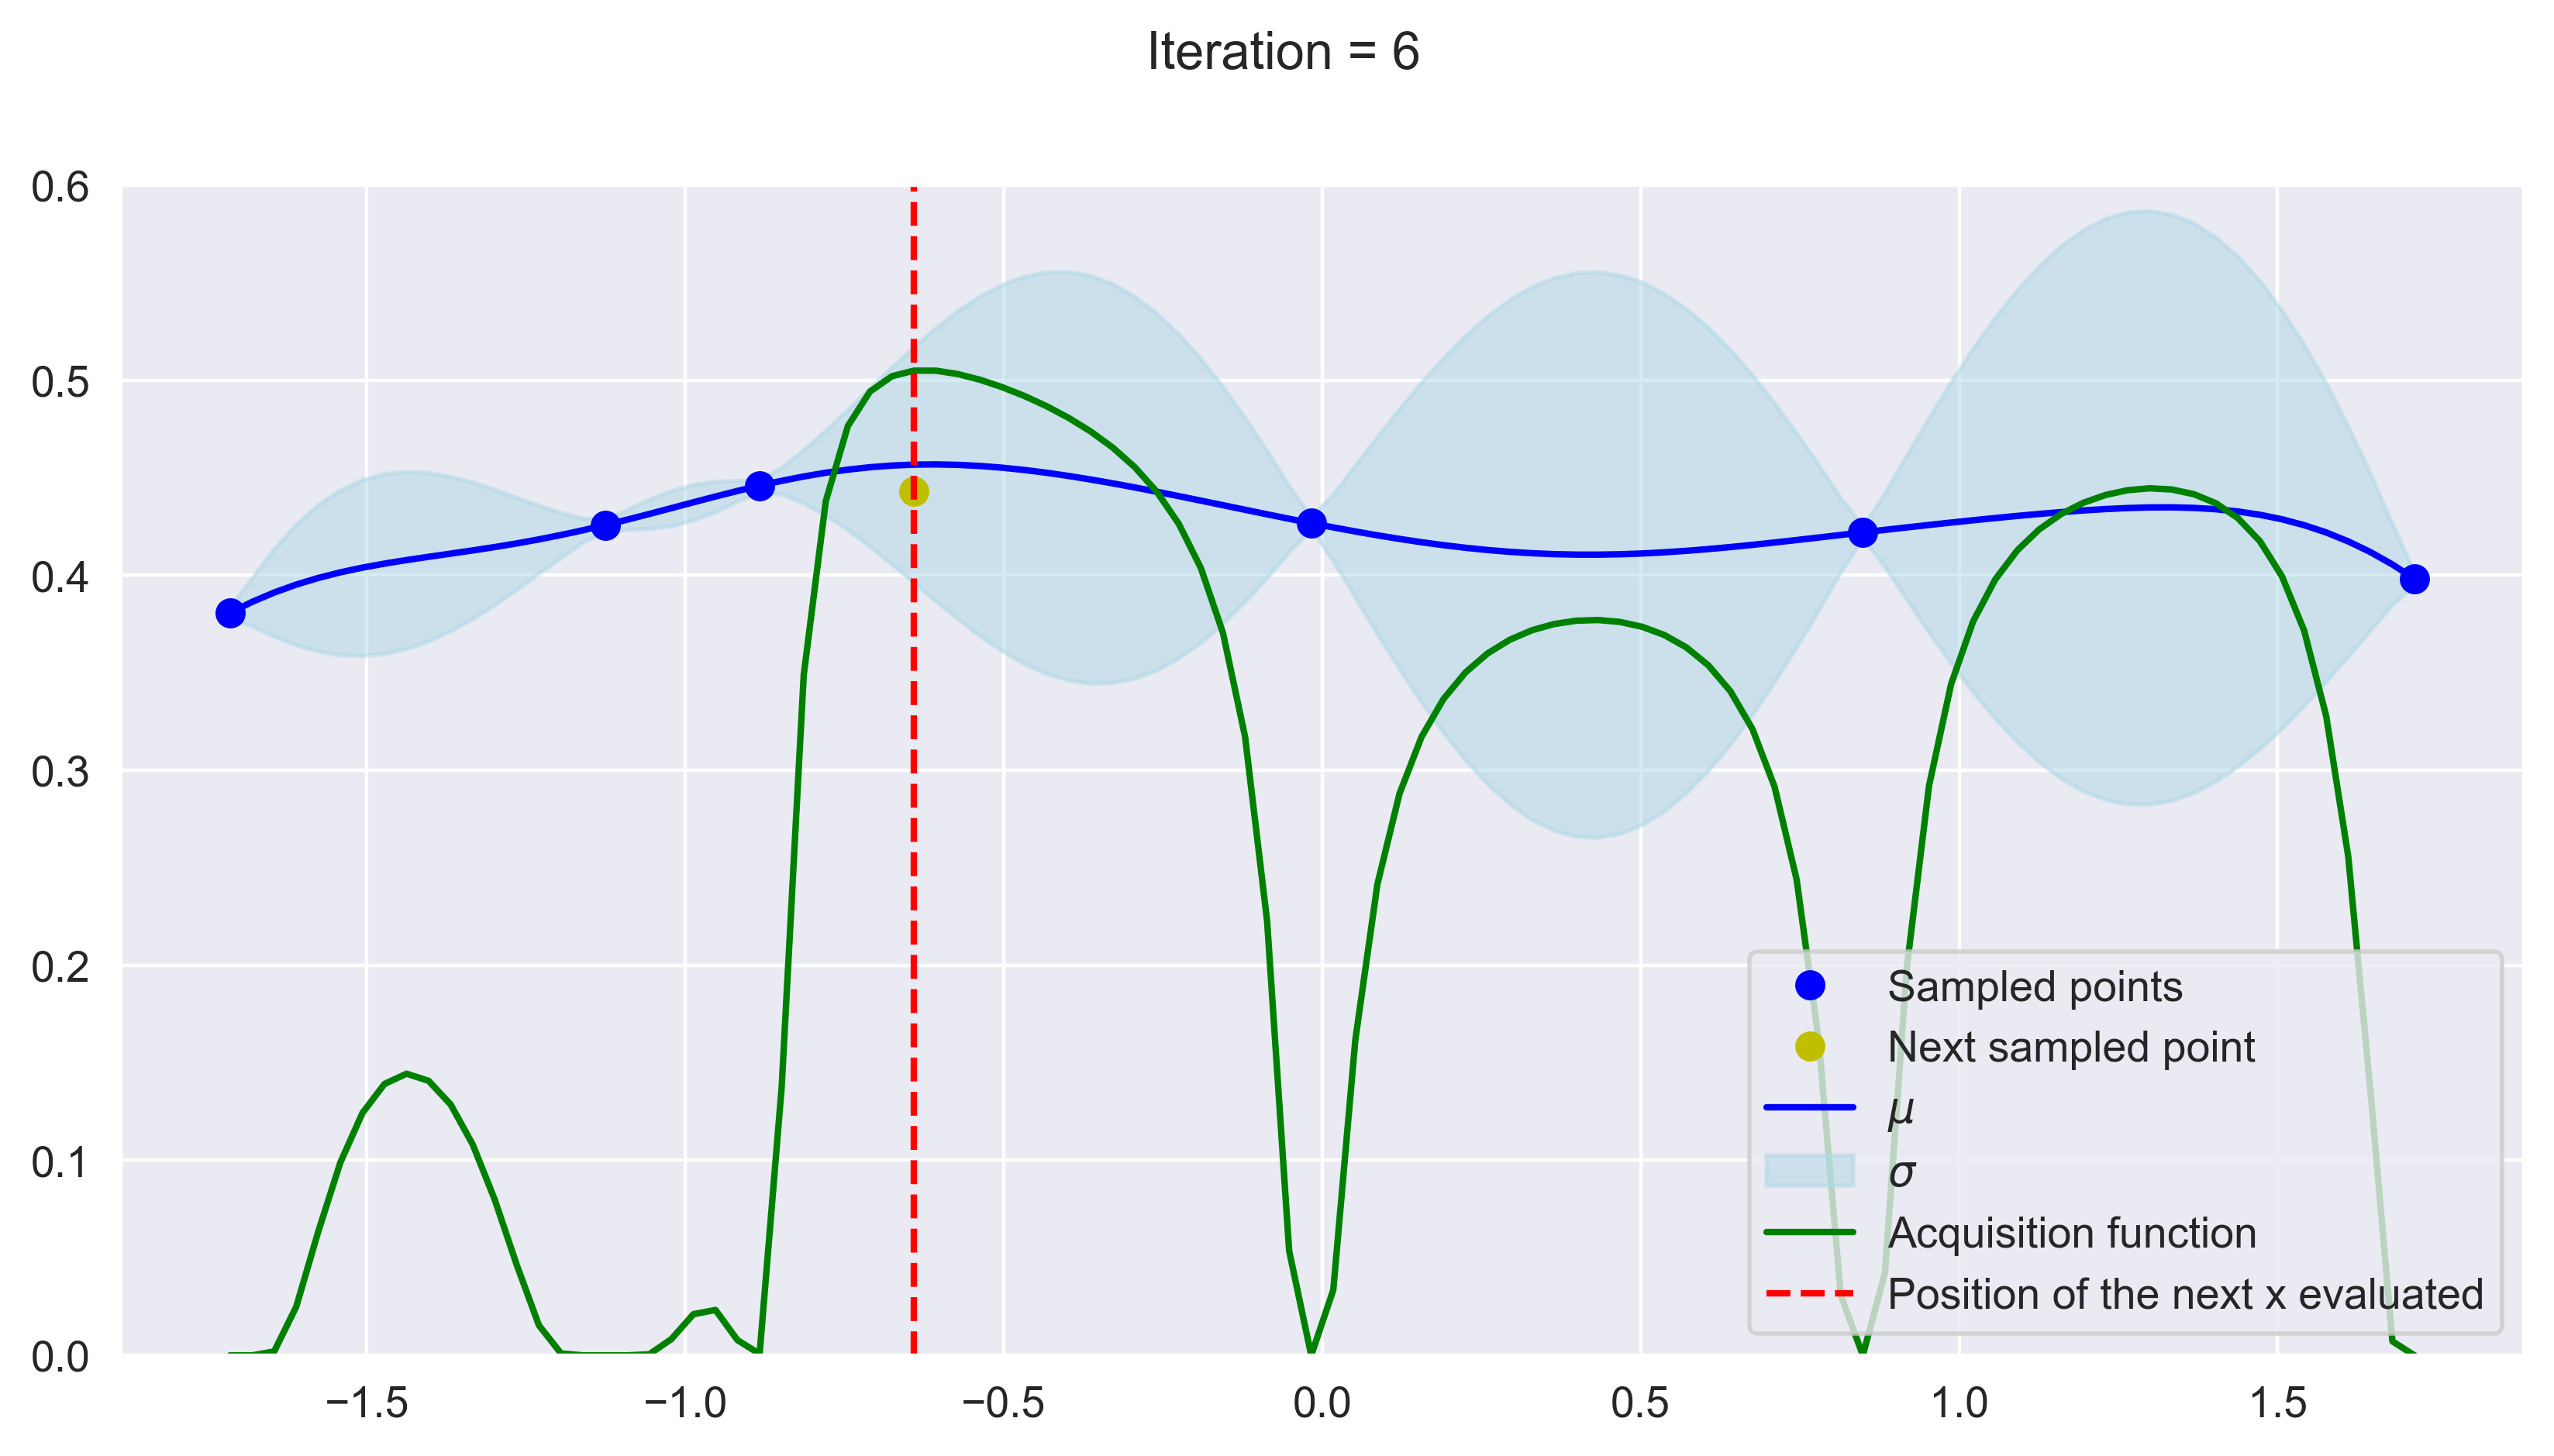

Run time for 6 iterations: 7.659


In [11]:
# parameters to save
lengthscales = []
output_vars = []
noise_vars = []
current_bests = []

tic = time.time()
for t in range(len(X_sample),len(X_sample) + T):
    ## we should optimize the GP hyperparameters before fitting the final GP and computing the acquisition functions
    lengthscale, output_var, noise_var = optimize_GP_hyperparams(X_sample, y_sample, 500, 5e-3, prior_mean, prior_std)
    print("lengtscale: %.3f, output_variance: %.5f, noise_variance %.5f, current_best: %.5f" %
          (lengthscale, output_var, noise_var, current_best))

    lengthscales.append(lengthscale)
    output_vars.append(output_var)
    noise_vars.append(noise_var)
    current_bests.append(current_best)
    
    # we have to fit the GP using the X_sample, y_sample and our training point
    mu, covariance = fit_predictive_GP(X_sample, y_sample, X, lengthscale, output_var, noise_var)
    std = np.sqrt(np.diag(covariance))

    ## calculate acquisition values for your acquisition function of choice
    if acquisition == 'probability':
        acquisition_values = probability_of_improvement(current_best,  mu, std, eps)
        # print(acquisition_values)
    elif acquisition == 'improvement':
        acquisition_values = expected_improvement(current_best,  mu, std, eps)
    elif acquisition == 'GP-UCB-approx':
        acquisition_values = GP_UCB_approx(mu, std, t, eps)
    elif acquisition == 'GP-UCB_original':
        acquisition_values = GP_UCB_original(mu, std, t)
    else:
        assert acquisition == 'GP-UCB', "You have insert a wrong acquisition function"
        acquisition_values = GP_UCB(mu, std, t, delta=eps)
    
    # we have to find the xt that maximizes this acquisition function
    xt = X[np.argmax(acquisition_values)]
    
    # query the objective
    y_new = query_the_objective(df, xt, param=PARAM)


    ## now we should create the plots
    if t > 0:
        if 1 == 2:
            fig, axs = plt.subplots(2, figsize=(10,5), dpi=400)
            fig.suptitle(f'Iteration = {t}')
            axs[0].fill_between(X.flat, mu - std, mu + std,  color='lightblue', alpha=0.5, label = r"$\sigma$")
            #axs[0].fill_between(X.flat, mu - noise_var, mu + noise_var, color='red', alpha=0.2, label=r"predictive")
            axs[0].plot(X, mu, 'b-', label=r'$\mu$')

            if len(X_sample) > 0:
                axs[0].plot(X_sample, y_sample, 'bo', label='Sampled points')
            axs[0].plot(xt, y_new, 'yo', label='Next sampled point')
            #axs[0].plot(X_sample[np.argmax(y_sample)], np.max(y_sample), 'go', label='Current best')
            #axs[0].set_xscale("log")
            axs[0].legend(["Sampled points", "Next sampled point", r'$\mu$', r'$\sigma$'], loc='lower left')

            #plot acquisition
            axs[1].plot(X, acquisition_values, '-', color = 'green', label = 'Acquisition function')
            axs[1].axvline(xt, color = 'red', linestyle = '--', label='Position of the next x evaluated')
            #axs[1].set_xscale("log")
            axs[1].legend(loc='upper left')
            #plt.show()
            plt.savefig(f'{acquisition}_{t}.png')
            fig.clf()
            plt.close()
            
        fig, axs = plt.subplots(1, figsize=(10,5), dpi=400)
        fig.suptitle(f'Iteration = {t}')
        fill_std = axs.fill_between(X.flat, mu - std, mu + std,  color='lightblue', alpha=0.5, label = r'$\sigma$')
        #axs.fill_between(X.flat, mu - noise_var, mu + noise_var, color='red', alpha=0.2, label=r"predictive")
        line_mu,= axs.plot(X, mu, 'b-', label=r'$\mu$')

        if len(X_sample) > 0:
            points_samples, = axs.plot(X_sample, y_sample, 'bo', label='Sampled points')
        point_new, = axs.plot(xt, y_new, 'yo', label='Next sampled point')

        #plot acquisition
        line_aqc,  = axs.plot(X, acquisition_values, '-', color = 'green', label = 'Acquisition function')
        line_next = axs.axvline(xt, color = 'red', linestyle = '--', label='Position of the next x evaluated')

        axs.legend(handles=[points_samples, point_new, line_mu, fill_std, line_aqc, line_next], loc='lower right')
        axs.set_ylim([0,.6])
        #plt.savefig(f'{acquisition}_eps_{eps}_{t}.png')
        #fig.clf()
        #plt.close()
        plt.show()

    # we compute the value of xt and we add xt and f(xt) in X_samples and y_samples
    X_sample.append(xt)
    # we append a noisy observation (should we?)
    y_sample.append(y_new)

    # update current best
    current_best = np.max(y_sample)
    
toc = time.time()
run_time = toc - tic
print("Run time for %d iterations: %.3f" % (t, run_time))

### Save the progess as a dictionary and a pickle file

In [139]:
import pickle

dct = {"X_sample":X_sample, 
       "y_sample":y_sample,
       "eps": eps, 
       "lengthscales": lengthscales,
       "output_vars": output_vars,
       "noise_vars": noise_vars,
       "current_bests": current_bests,
       "mu": mu,
       "std": std,
       "time": run_time,
      }

with open(f"{PARAM}_{acquisition}_eps_{eps}_2.pkl", "wb") as fp:
    pickle.dump(dct, fp, pickle.HIGHEST_PROTOCOL)

### Optimal values

In [ ]:
print("Best SRC:", np.max(y_sample))
print("Learning rate for best SRC:", 0.1**(( X_sample[np.argmax(y_sample)] * X_std + X_mean)*100/20))
print("Leaves for best SRC:", X_sample[np.argmax(y_sample)] * X_std + X_mean)

print('\nMaximum mu:', np.max(mu))
print('\nMaximum mu position:', X[np.argmax(mu)])
print("Corresponding learning rate:", 0.1**(( X[np.argmax(mu)] * X_std + X_mean)*100/20))
print("Corresponding leaves:", X[np.argmax(mu)] * X_std + X_mean)
print("Corresponding frac:", X[np.argmax(mu)] * X_std + X_mean)
print("Corresponding l2:",  0.1**(( X[np.argmax(mu)] * X_std + X_mean)*6))

print("Time:", run_time)
print("Noise_variance:", noise_var)

fig, axs = plt.subplots(1, figsize=(10,5), dpi=400)
fig.suptitle(f'Iteration = {t}')
fill_std = axs.fill_between(X.flat, mu - std, mu + std,  color='lightblue', alpha=0.5, label = r'$\sigma$')
#axs.fill_between(X.flat, mu - noise_var, mu + noise_var, color='red', alpha=0.2, label=r"predictive")
line_mu,= axs.plot(X, mu, 'b-', label=r'$\mu$')

if len(X_sample) > 0:
    points_samples, = axs.plot(X_sample, y_sample, 'bo', label='Sampled points')
point_new, = axs.plot(xt, y_new, 'yo', label='Next sampled point')
#axs.plot(X_sample[np.argmax(y_sample)], np.max(y_sample), 'go', label='Current best')
#axs.set_xscale("log")


#plot acquisition
line_aqc,  = axs.plot(X, acquisition_values, '-', color = 'green', label = 'Acquisition function')
line_next = axs.axvline(xt, color = 'red', linestyle = '--', label='Position of the next x evaluated')

axs.legend(handles=[points_samples, point_new, line_mu, fill_std, line_aqc, line_next], loc='lower right')
axs.set_ylim([0,.6])
plt.show()

### Load values from file
Here, I simply load saved results (pickle file) and calculate the optimal values

In [ ]:
import pickle
with open(f"leaves_{acquisition}_eps_{eps}.pkl", "rb") as fp:
    new_dict = pickle.load(fp)
    
    
y_sample = new_dict["y_sample"]
X_sample = new_dict["X_sample"]
mu = new_dict["mu"]
run_time = new_dict["time"]
noise_vars = new_dict["noise_vars"]
std = new_dict["std"]
eps = new_dict["eps"]

noise_var = noise_vars[-1]

    
print("Best SRC:", np.max(y_sample))
print("Learning rate for best SRC:", 0.1**(( X_sample[np.argmax(y_sample)] * X_std + X_mean)*100/20))

print('\nMaximum mu:', np.max(mu))
print("No transform, learning rate:", X[np.argmax(mu)])
print("Corresponding learning rate:", 0.1**(( X[np.argmax(mu)] * X_std + X_mean)*100/20))
print("Corresponding leaves:", X[np.argmax(mu)] * X_std + X_mean)

print("Time:", run_time)
print("Noise_variance:", noise_var)

fig, axs = plt.subplots(1, figsize=(4,4), dpi=400)
fig.suptitle('Probability of Improvement')
fill_std = axs.fill_between(X.flat, mu - std, mu + std,  color='lightblue', alpha=0.5, label = r'$\sigma$')
#axs.fill_between(X.flat, mu - noise_var, mu + noise_var, color='red', alpha=0.2, label=r"predictive")
line_mu, = axs.plot(X, mu, 'b-', label=r'$\mu$')

if len(X_sample) > 0:
    points_samples, = axs.plot(X_sample, y_sample, 'bo', label='Sampled points', alpha=0.5)
point_max, = axs.plot(X_sample[np.argmax(y_sample)], np.max(y_sample), 'ro', label='Current best', alpha=0.5)
point_mu = axs.scatter(X[np.argmax(mu)], np.max(mu), s=100, marker='x', color='red', label='Maximum')


axs.legend(handles=[points_samples, point_max, line_mu, fill_std, point_mu], loc='lower right')
axs.set_ylim([.2,.55])
#plt.show()
plt.savefig('Probability of Improvement.png')
fig.clf()
plt.close()

### Which learning rate is better?
I test all the optimal learning rate to see how it performs on average.


In [ ]:
opt_param = 0.05

srcs = []
for _ in tqdm(range(50)):
    srcs.append(query_the_objective(df, opt_param, param=PARAM, transform=False))
    
print("Mean:", np.mean(srcs))
print("Std:", np.std(srcs))





# Multiple parameters
Now we will look at multiple parameters. The parameters to inspect are
- learning rate
- number of leaves
- feature fraction
- l2_regularization

For each parameter we will inspect a different number of values. To ensure numerical stability, all the variables are parameterized from [0, 1].

In [13]:
from bayesian_optimization import fit_predictive_GP_multiple, optimize_GP_hyperparams_multiple

TRANSFORM = True

def query_the_objective_multiple(X_sample, param, transform=TRANSFORM):
    
    lr = X_sample[0]
    leaves = X_sample[1]
    frac = X_sample[2]
    l2 = X_sample[3]
    
    
    if transform:
        lr = lr * param["lr"].std + param["lr"].mu
        leaves = leaves * param["leaves"].std + param["leaves"].mu
        frac = frac * param["frac"].std + param["frac"].mu
        l2 = l2 * param["l2"].std + param["l2"].mu
        
        lr = 0.1**(lr*100/20)
        
    
    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2'},
        'num_leaves': int(leaves),
        'learning_rate': lr,
        'feature_fraction': frac,
        'lambda_l2': l2, 
        #'bagging_fraction': 0.8,
        #'bagging_freq': 5,
        'max_bin': 255,
        'verbose': 0
    }
    

    rho = lightgbm_functions.train_gbm(df, params, verbose=False)
        
    return rho

First, we create the search space and then we standardize the parameters to have mean=0 and std=1.

In [14]:
import itertools

class Parameter:
    def __init__(self, array):
        self.array = array
        self.mu = np.mean(self.array)
        self.std = np.std(self.array)
        self.standardized = (self.array - self.mu) / self.std
        

lr = Parameter(np.linspace(.1,0.5,41).tolist())        
leaves = Parameter([20, 40, 80, 100, 120, 140, 160, 180, 200, 220, 240])
frac = Parameter([.5, .6, .7, .8, .9])
l2 = Parameter([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

param = {"lr":lr, "leaves":leaves, "frac":frac, "l2":l2}


if TRANSFORM:
    X = list(itertools.product(lr.standardized, leaves.standardized, frac.standardized, l2.standardized))
else:
    X = list(itertools.product(lr.array, leaves.array, frac.array, l2.array))
    
print("Combination in search space:", len(X))

Combination in search space: 11275


Sample initial data points as well as query the oracle (query the objective)

In [15]:
# Sample initial data points
sample = 'random'

# number of initial random samples
init_samples = 5

# array for the points x' and repective f(x') that we sample using the acquisition function
X_sample = []
y_sample = []

if sample == 'uniform':
    1 + 1
    # How do we do that smartest?
    
elif sample == 'random':
    # get some random samples
    for _ in tqdm(range(init_samples)):
        # sample a point at random
        xt = X[np.random.randint(0, len(X))]
        X_sample.append(xt)
        
        # evaluate the point by query the function
        y_sample.append(query_the_objective_multiple(xt, param))
    
# bayesian optimization loop
# compute the current best 
current_best = np.max(y_sample)

100%|██████████| 5/5 [00:14<00:00,  3.31s/it]


### Bayesian Optimization
First, we define the prior, the free parameter $\varepsilon$, acquistion function and the number of iterations.

In [17]:
# Prior over lengthscale
print(np.mean(y_sample))
print(np.std(y_sample))

prior_mean = 0.4 # Similar to mean(y_sample)
prior_std = 0.1 # Should be a little above std(sample) to avoid numerical issues in inverting matrices

# trade-off between exploration and explotation
eps = np.linspace(0,1,10001) # alternatively, set equal to 0.01

# Choose acquisition function
acquisition = 'probability'

# number of iterations
T = 2

0.4311126003045869
0.009174465989502133


Perform the Bayesian Optimization.

In [18]:
# plots
lr_plot = False
line_plot = False

lengthscales = []
output_vars = []
noise_vars = []
current_bests = []

tic = time.time()
for t in range(len(X_sample),len(X_sample) + T):
    ## we should optimize the GP hyperparameters before fitting the final GP and computing the acquisition
    ## functions
    lengthscale, output_var, noise_var = optimize_GP_hyperparams_multiple(X_sample, y_sample, 500, 5e-3, prior_mean, prior_std)
    
    lengthscales.append(lengthscale)
    output_vars.append(output_var)
    noise_vars.append(noise_var)
    current_bests.append(current_best)
    
    # we have to fit the GP using the X_sample, y_sample and our training point
    mu, covariance = fit_predictive_GP_multiple(X_sample, y_sample, X, lengthscale, output_var, noise_var)
    # get the standard deviation
    std = np.sqrt(np.diag(covariance))
    
    #print("current_best", current_best, "mu", mu, "std", std, "eps", eps)

    ## calculate acquisition values for your acquisition function of choice
    ## now we have to use the acquisition function
    if acquisition == 'probability':
        acquisition_values = probability_of_improvement(current_best,  mu, std, eps[-t])
        # print(acquisition_values)
    elif acquisition == 'improvement':
        acquisition_values = expected_improvement(current_best,  mu, std, eps[-t])
    elif acquisition == 'GP-UCB-approx':
        acquisition_values = GP_UCB_approx(mu, std, t, eps[-t])
    elif acquisition == 'GP-UCB_original':
        acquisition_values = GP_UCB_original(mu, std, t)
    else:
        assert acquisition == 'GP-UCB', "You have insert a wrong acquisition function"
        acquisition_values = GP_UCB(mu, std, t)
    
    # we have to find the xt that maximizes this acquisition function
    xt = X[np.argmax(acquisition_values)]

    # Query the objective
    y_new = query_the_objective_multiple(xt, param)

    ## now we should create the plots
    if t > 0:
        if lr_plot:
            plot_iteration(0, X_sample, y_sample, xt, y_new, X, mu, std)
        
        if line_plot:
            tmp_X_sample = np.array(X_sample)
            plt.figure(figsize=(5, 3), dpi=100)
            for i in range(len(tmp_X_sample)-1):
                plt.plot(range(4), tmp_X_sample[i,:], 'go-', alpha=0.1)

            plt.plot(range(4), tmp_X_sample[ -1, :], 'go-', label = "Last sample")    
            plt.plot(range(4), tmp_X_sample[ np.argmax(y_sample), :], 'b-o', label = "Current best") 
            plt.legend()
            plt.show()

    # we compute the value of xt and we add xt and f(xt) in X_samples and y_samples
    X_sample.append(xt)
    # we append a noisy observation (should we?)
    y_sample.append(y_new)
    # remove sample from test set
    # del X[np.argmax(acquisition_values)]

    # update current best
    current_best = np.max(y_sample)
    
    
    print("t: %d, lengtscale: %.3f, output_variance: %.5f, noise_variance %.5f, current_best %.5f, max mu %.3f" %
          (t, lengthscale, output_var, noise_var, current_best, np.max(mu)))
    
print("Total time for %d: %.5f" % (T, time.time()-tic))

t: 5, lengtscale: 0.377, output_variance: 0.18474, noise_variance 0.00001, current_best 0.44756, max mu 0.448
t: 6, lengtscale: 0.413, output_variance: 0.15634, noise_variance 0.00001, current_best 0.46024, max mu 0.455
Total time for 2: 24.58028


### Compute the optimal values

In [19]:
# Optimal parameters
tmp_X_sample = np.array(X_sample)
print("Best SRC:", current_best)
print("Optimal parameters:")
print("\tlr:", tmp_X_sample[ np.argmax(y_sample), 0] * lr.std + lr.mu)
print("\tleaves:", tmp_X_sample[ np.argmax(y_sample), 1] * leaves.std + leaves.mu)
print("\tfrac:", tmp_X_sample[ np.argmax(y_sample), 2] * frac.std + frac.mu)
print("\tl2:", tmp_X_sample[ np.argmax(y_sample), 3] * l2.std + l2.mu)

print("\n\nIn the perspective of mu")
print("Best SRC:", np.max(mu))
print("Optimal parameters:", np.argmax(mu))
print("\tlr:", X[ np.argmax(mu)][0] * lr.std + lr.mu)
print("\tleaves:", X[ np.argmax(mu)][1] * leaves.std + leaves.mu)
print("\tfrac:", X[ np.argmax(mu)][2] * frac.std + frac.mu)
print("\tl2:", X[ np.argmax(mu)][3] * l2.std + l2.mu)
print("\tlr:", X[ np.argmax(mu)][0] )
print("\tleaves:", X[ np.argmax(mu)][1] )
print("\tfrac:", X[ np.argmax(mu)][2] )
print("\tl2:", X[ np.argmax(mu)][3] )

Best SRC: 0.46023718125317664
Optimal parameters:
	lr: 0.35
	leaves: 200.0
	frac: 0.5
	l2: 0.01


In the perspective of mu
Best SRC: 0.45528844584586986
Optimal parameters: 8727
	lr: 0.41000000000000003
	leaves: 200.0
	frac: 0.5
	l2: 0.0010000000000000009
	lr: 0.9296696802013681
	leaves: 0.9268474973316578
	frac: -1.4142135623730945
	l2: -0.5431931730330763


### Save the progess as a dictionary and a pickle file

In [317]:
dct = {"lr":lr, "leaves":leaves, "frac":frac, "l2":l2, 
       "X_sample":X_sample, "y_sample":y_sample, "eps": eps, "mu": mu, "std": std, "t": t}

with open(f"standardized_{acquisition}_3.pkl", "wb") as fp:
    pickle.dump(dct, fp, pickle.HIGHEST_PROTOCOL)

In [217]:
with open(f"standardized_{acquisition}.pkl", "rb") as fp:
    new_dict = pickle.load(fp)
    
X_sample = new_dict["X_sample"]
y_sample = new_dict["y_sample"]

### Plot the acquired points as lines

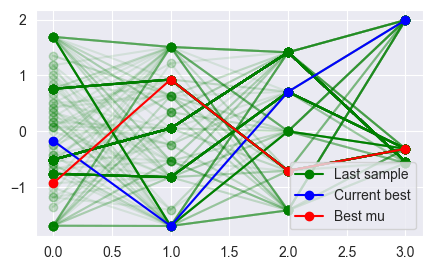

In [304]:
plt.figure(figsize=(5, 3), dpi=100)
for i in range(len(tmp_X_sample)-1):
    plt.plot(range(4), tmp_X_sample[i,:], 'go-', alpha=0.1)
    
plt.plot(range(4), tmp_X_sample[ -1, :], 'go-', label = "Last sample")    
plt.plot(range(4), tmp_X_sample[ np.argmax(y_sample), :], 'b-o', label = "Current best")
plt.plot(range(4), X[ np.argmax(mu)], 'r-o', label = "Best mu")
plt.legend()
plt.show()

### Plot $\mu$ and $\sigma$ for the acquisition function averaged across the other hyper-parmeters values.

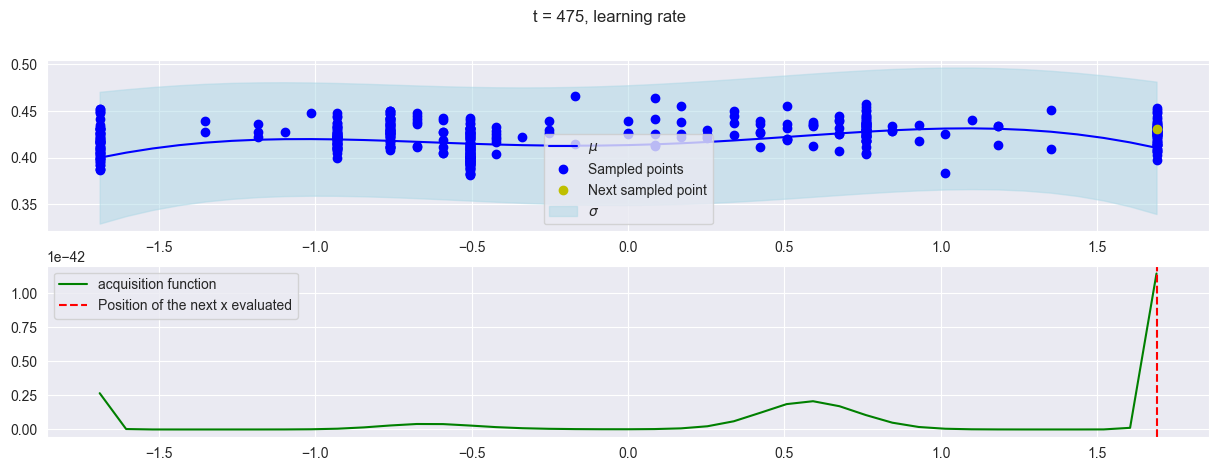

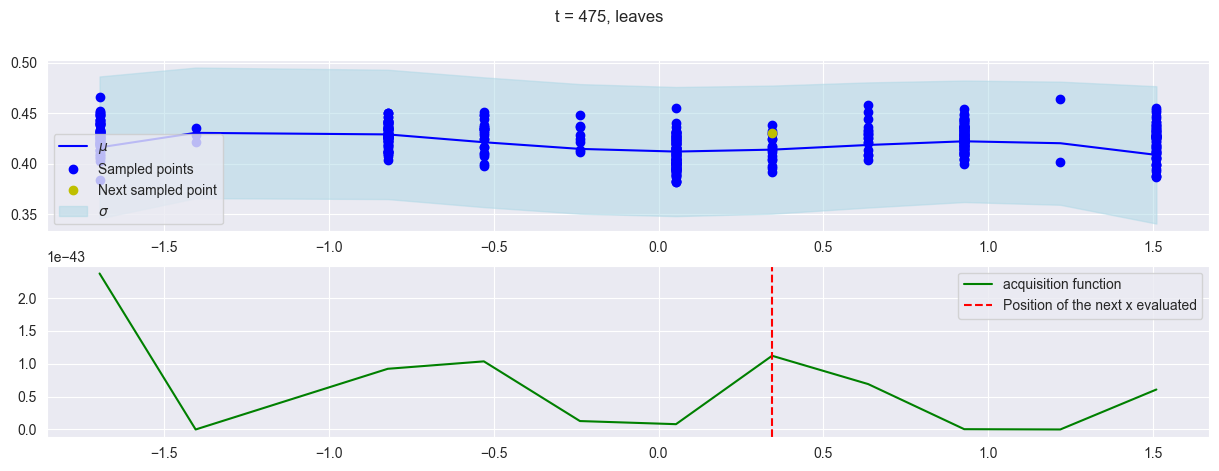

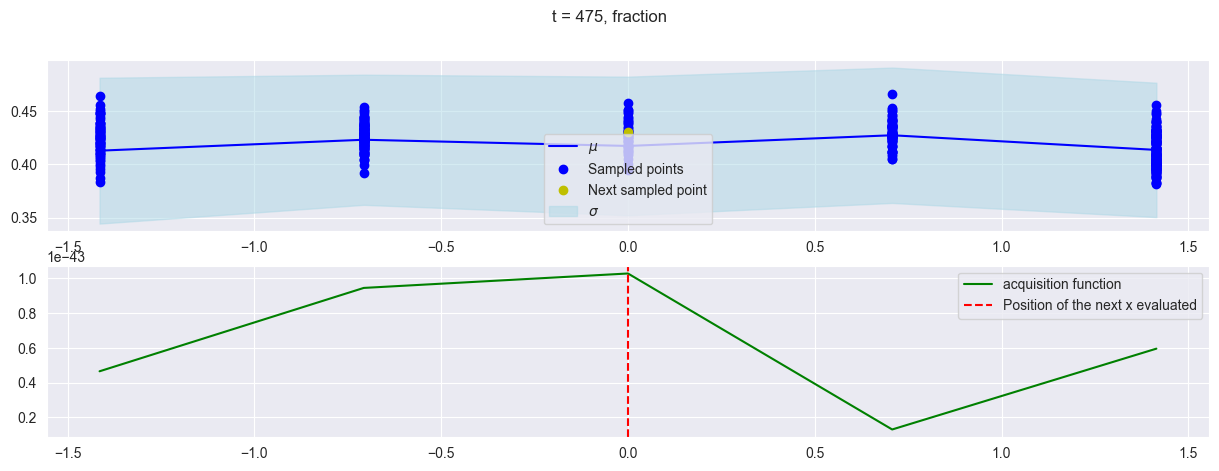

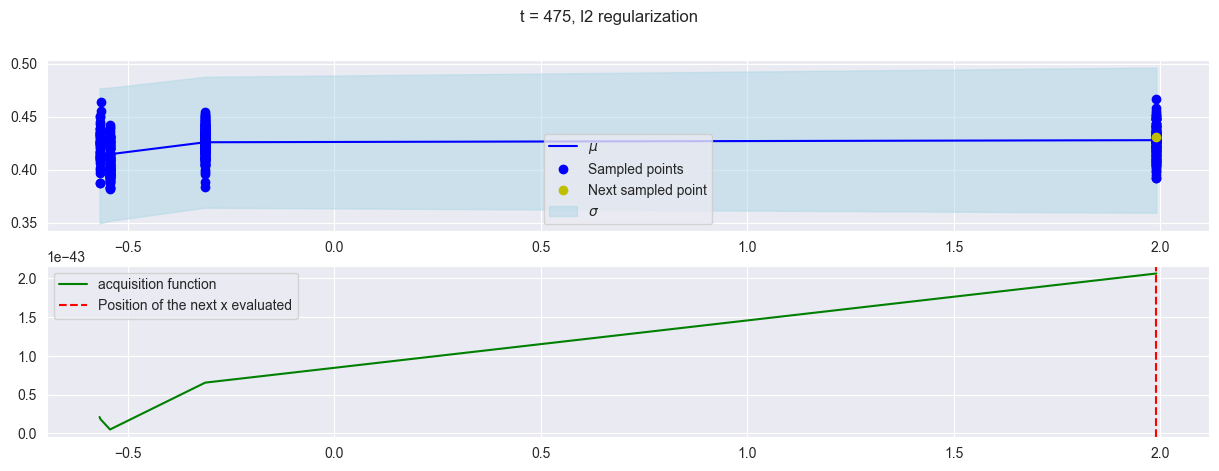

In [311]:
def plot_iteration(ptp, X_sample, y_sample, xt, y_new, X, mu, std):
    tmp_X_sample = np.array(X_sample)
    tmp = np.array(X)

    unq = np.unique(tmp[:,ptp])

    average = 'mean'
    
    v_mu, v_std, v_acq = [], [], []
    for v in unq:
        if average == 'mean':
            v_mu.append(np.mean(mu[tmp[:,ptp]==v]))
            v_std.append(np.mean(std[tmp[:,ptp]==v]))
            v_acq.append(np.mean(acquisition_values[tmp[:,ptp]==v]))
        else:
            v_mu.append(np.median(mu[tmp[:,ptp]==v]))
            v_std.append(np.median(std[tmp[:,ptp]==v]))
            v_acq.append(np.median(acquisition_values[tmp[:,ptp]==v]))

    v_mu, v_std = np.array(v_mu), np.array(v_std)

    title = "learning rate"
    
    if ptp == 1:
        title = "leaves"
    elif ptp == 2:
        title = "fraction"
    elif ptp == 3:
        title = "l2 regularization"
    
    fig, axs = plt.subplots(2, figsize=(15,5), dpi=100)
    fig.suptitle(f't = {t}, {title}')
    axs[0].fill_between(unq, v_mu - v_std, v_mu + v_std,  color='lightblue', alpha=0.5, label = r"$\sigma$")
    # axs[0].fill_between(X.flat, mu - noise_, mu + noise_, color='red', alpha=0.4, label=r"predictive")
    axs[0].plot(unq, v_mu, 'b-', label=r'$\mu$')

    if len(X_sample) > 0:
        axs[0].plot(tmp_X_sample[:,ptp], y_sample, 'bo', label='Sampled points')
    axs[0].plot(xt[ptp], y_new, 'yo', label='Next sampled point')
    axs[0].legend()

    #plot acquisition
    axs[1].plot(unq, v_acq, '-', color = 'green', label = 'acquisition function')
    axs[1].axvline(xt[ptp], color = 'red', linestyle = '--', label='Position of the next x evaluated')
    axs[1].legend()
    plt.show()

plot_iteration(0, X_sample, y_sample, xt, y_new, X, mu, std)
plot_iteration(1, X_sample, y_sample, xt, y_new, X, mu, std)
plot_iteration(2, X_sample, y_sample, xt, y_new, X, mu, std)
plot_iteration(3, X_sample, y_sample, xt, y_new, X, mu, std)

## Test best parameters

In [321]:
opt_parameters = [-1.098700531147072, -1.4035119245307965, -0.7071067811865472, -0.312831352408362]

rhos = []
for _ in tqdm(range(50)):
    rhos.append(query_the_objective_multiple(opt_parameters, param, transform=True))
    
print("Mean:", np.mean(rhos))
print("Std:", np.std(rhos))
print("Max:", np.max(rhos))

100%|██████████| 50/50 [00:35<00:00,  1.44it/s]

Mean: 0.42923860797919083
Std: 0.01184449619404586
Max: 0.45136068420671943


Now add all the data points to the lists of acquired data points for further optimization.

In [ ]:
print(len(X_sample))
for _ in range(50):
    X_sample.append(tuple(opt_parameters))
y_sample.extend(rhos)
print(len(X_sample))
print(len(y_sample))